# Event Splitter Validation

Validate saved event-splitter predictions using parquet outputs and truth labels from the main data files.

This notebook does **not** run model inference.


In [1]:
import torch
import numpy as np
import polars as pl
from pathlib import Path
from datetime import datetime

from pioneerml.common.zenml import utils as zenml_utils
from pioneerml.common.evaluation.plots import (
    plot_multilabel_confusion_matrix,
    plot_roc_curves,
    plot_precision_recall_curves,
    plot_probability_distributions,
    plot_confidence_analysis,
)

PROJECT_ROOT = zenml_utils.find_project_root()
zenml_utils.setup_zenml_for_notebook(root_path=PROJECT_ROOT, use_in_memory=True)

print(f"Project root: {PROJECT_ROOT}")


Using ZenML repository root: /workspace
Ensure this is the top-level of your repo (.zen must live here).
Project root: /workspace


## List Available Prediction Files

Find saved `event_splitter` prediction parquet files.


In [2]:
# List available saved event-splitter prediction files
prediction_dir = Path(PROJECT_ROOT) / "data" / "event_splitter"
prediction_files = sorted(prediction_dir.glob("*_preds.parquet"))
if not prediction_files:
    raise ValueError(f"No prediction parquet files found in {prediction_dir}")

print(f"Found {len(prediction_files)} prediction file(s).")
for i, p in enumerate(prediction_files[:10]):
    print(f"[{i}] {p.name}")


Found 1 prediction file(s).
[0] ml_output_000_preds.parquet


## Prediction Source

Validation uses previously exported prediction parquet files from `data/event_splitter`.


In [3]:
# Validation now loads predictions from parquet files (no model inference run in this notebook)
print("Validation mode: load existing predictions + truth from parquet files.")


Validation mode: load existing predictions + truth from parquet files.


## Load Validation Data

Load main validation parquet inputs and aligned event-splitter prediction files.


In [4]:
# Load validation parquet inputs and aligned event-splitter prediction files

def _pick_pred(pred_dir: Path, main_path: Path) -> Path | None:
    candidates = [
        pred_dir / f"{main_path.stem}_preds.parquet",
        pred_dir / f"{main_path.stem}_preds_latest.parquet",
    ]
    for c in candidates:
        if c.exists():
            return c
    return None

main_dir = Path(PROJECT_ROOT) / "data"
main_paths = sorted(main_dir.glob("ml_output_*.parquet"))

# Example: uncomment to use a smaller subset
main_paths = main_paths[:1]

prediction_dir = Path(PROJECT_ROOT) / "data" / "event_splitter"
paired = []
for mp in main_paths:
    pp = _pick_pred(prediction_dir, mp)
    if pp is not None:
        paired.append((str(mp.resolve()), str(pp.resolve())))

if not paired:
    raise RuntimeError(
        "No aligned main/event-splitter prediction pairs found. "
        "Run event-splitter inference first."
    )

parquet_paths = [p[0] for p in paired]
event_splitter_pred_paths = [p[1] for p in paired]

print(f"Validation files: {len(parquet_paths)}")
for p in parquet_paths:
    print(" -", p)
print(f"Event-splitter prediction files: {len(event_splitter_pred_paths)}")


Validation files: 1
 - /workspace/data/ml_output_000.parquet
Event-splitter prediction files: 1


## Load Predictions And Truth

Load saved edge-affinity predictions and reconstruct truth edge labels from `hits_particle_mask`.


In [5]:
# Load predictions from saved parquet outputs and build truth labels from main parquet files
pred_blocks = []
target_blocks = []

for main_path, pred_path in zip(parquet_paths, event_splitter_pred_paths, strict=True):
    mask_flat = (
        pl.scan_parquet(main_path)
        .select(["hits_particle_mask"])
        .with_columns(
            pl.int_range(pl.len(), dtype=pl.UInt32).alias("row_idx"),
            pl.int_ranges(
                pl.lit(0),
                pl.col("hits_particle_mask").list.len(),
                dtype=pl.UInt32,
            ).alias("node_idx"),
        )
        .explode(["node_idx", "hits_particle_mask"])
        .filter(pl.col("node_idx").is_not_null())
        .select(
            "row_idx",
            "node_idx",
            pl.col("hits_particle_mask").cast(pl.Int32).alias("hit_mask"),
        )
        .collect()
    )

    pred_flat = (
        pl.scan_parquet(pred_path)
        .select(["edge_src_index", "edge_dst_index", "pred_edge_affinity"])
        .with_columns(
            pl.int_range(pl.len(), dtype=pl.UInt32).alias("row_idx"),
            pl.int_ranges(
                pl.lit(0),
                pl.col("edge_src_index").list.len(),
                dtype=pl.UInt32,
            ).alias("edge_idx"),
        )
        .explode(["edge_idx", "edge_src_index", "edge_dst_index", "pred_edge_affinity"])
        .filter(pl.col("edge_idx").is_not_null())
        .select(
            "row_idx",
            "edge_idx",
            pl.col("edge_src_index").cast(pl.UInt32),
            pl.col("edge_dst_index").cast(pl.UInt32),
            pl.col("pred_edge_affinity").cast(pl.Float32),
        )
        .collect()
    )

    if mask_flat.height == 0 and pred_flat.height == 0:
        continue

    src_mask = mask_flat.rename({"node_idx": "edge_src_index", "hit_mask": "src_mask"})
    dst_mask = mask_flat.rename({"node_idx": "edge_dst_index", "hit_mask": "dst_mask"})

    joined = (
        pred_flat
        .join(src_mask, on=["row_idx", "edge_src_index"], how="left")
        .join(dst_mask, on=["row_idx", "edge_dst_index"], how="left")
        .sort(["row_idx", "edge_idx"])
    )

    if joined.height != pred_flat.height:
        raise RuntimeError(
            f"Edge alignment mismatch for {main_path} vs {pred_path} "
            f"(pred={pred_flat.height}, matched={joined.height})"
        )

    has_invalid_edge_index = joined.select(
        pl.any_horizontal([pl.col("src_mask").is_null(), pl.col("dst_mask").is_null()])
        .any()
        .alias("has_null")
    ).item()
    if has_invalid_edge_index:
        raise RuntimeError(f"Invalid edge node index found while aligning {pred_path}")

    target_np = (
        joined.select(
            (((pl.col("src_mask") & pl.col("dst_mask")) & 0x7) != 0)
            .cast(pl.Float32)
            .alias("target_edge_affinity")
        )
        .to_numpy()
    )
    pred_np = joined.select("pred_edge_affinity").to_numpy()

    target_blocks.append(target_np.astype(np.float32, copy=False))
    pred_blocks.append(pred_np.astype(np.float32, copy=False))

if not pred_blocks:
    raise RuntimeError("No edge predictions found after loading parquet files.")

predictions = torch.from_numpy(np.concatenate(pred_blocks, axis=0).astype(np.float32, copy=False))
targets = torch.from_numpy(np.concatenate(target_blocks, axis=0).astype(np.float32, copy=False))

metrics_latest = (Path(PROJECT_ROOT) / "data" / "event_splitter" / "metrics_latest.json")
export_info = {
    "predictions_paths": event_splitter_pred_paths,
    "metrics_path": str(metrics_latest) if metrics_latest.exists() else None,
}

print("Loaded predictions from parquet files:")
print(f"  Pairs used: {len(parquet_paths)}")
print(f"  Predictions shape: {tuple(predictions.shape)}")
print(f"  Targets shape: {tuple(targets.shape)}")
print(f"  Predictions range: [{predictions.min():.4f}, {predictions.max():.4f}]")
print("export:", export_info)


Loaded predictions from parquet files:
  Pairs used: 1
  Predictions shape: (8230284, 1)
  Targets shape: (8230284, 1)
  Predictions range: [0.0001, 1.0000]
export: {'predictions_paths': ['/workspace/data/event_splitter/ml_output_000_preds.parquet'], 'metrics_path': '/workspace/data/event_splitter/metrics_latest.json'}


## Generate Validation Plots

Create event-splitter validation plots.


In [6]:
# Create output directory for plots
plots_dir = Path(PROJECT_ROOT) / "artifacts" / "validation_plots" / "event_splitter"
plots_dir.mkdir(parents=True, exist_ok=True)

timestamp_str = datetime.now().strftime("%Y%m%d_%H%M%S")
plot_prefix = f"event_splitter_{timestamp_str}"

class_names = ["same_particle_affinity"]

print(f"Generating validation plots in: {plots_dir}")
print(f"Class names: {class_names}")


Generating validation plots in: /workspace/artifacts/validation_plots/event_splitter
Class names: ['same_particle_affinity']


### Confusion Matrix

The confusion matrix shows how well the model classifies edge affinity (same-particle vs not-same-particle).

**How to interpret:**
- **Diagonal elements**: Correct predictions.
- **Off-diagonal elements**: Misclassifications.
- **Normalized values**: Percentage by true class.

**What to look for:**
- High diagonal values.
- Low false positives and false negatives.


1. Generating confusion matrix...


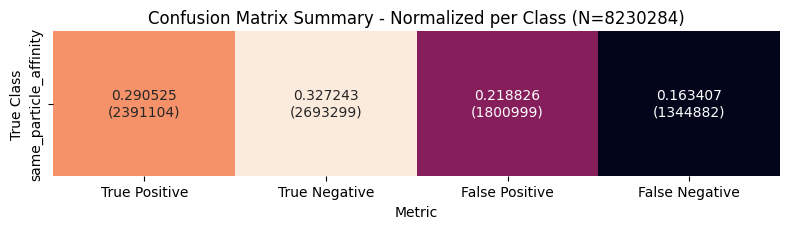

'/workspace/artifacts/validation_plots/event_splitter/event_splitter_20260219_021428_confusion_matrix_summary.png'

In [7]:
# 1. Confusion Matrix
print("1. Generating confusion matrix...")

plot_multilabel_confusion_matrix(
    predictions=predictions,
    targets=targets,
    class_names=class_names,
    precision=6,
    view_mode="summary",
    summary_mode="default",
    threshold=0.5,
    normalize=True,
    save_path=plots_dir / f"{plot_prefix}_confusion_matrix_summary.png",
    show=True,
)


### ROC Curves (Receiver Operating Characteristic)

ROC shows TPR vs FPR across thresholds.

**What to look for:**
- Curves near the top-left corner.
- Larger AUC indicates stronger separability.


2. Generating ROC curves...


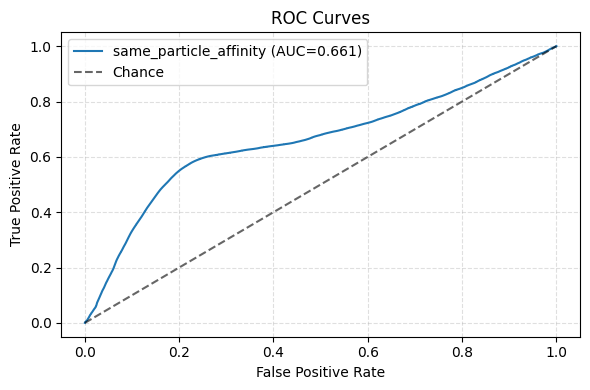

'/workspace/artifacts/validation_plots/event_splitter/event_splitter_20260219_021428_roc_curves.png'

In [8]:
# 2. ROC Curves
print("2. Generating ROC curves...")
plot_roc_curves(
    predictions=predictions,
    targets=targets,
    class_names=class_names,
    save_path=plots_dir / f"{plot_prefix}_roc_curves.png",
    show=True,
)


### Precision-Recall Curves

Precision-recall is especially useful with class imbalance.

**What to look for:**
- High precision sustained over strong recall.
- Higher average precision indicates better edge-affinity ranking.


3. Generating precision-recall curves...


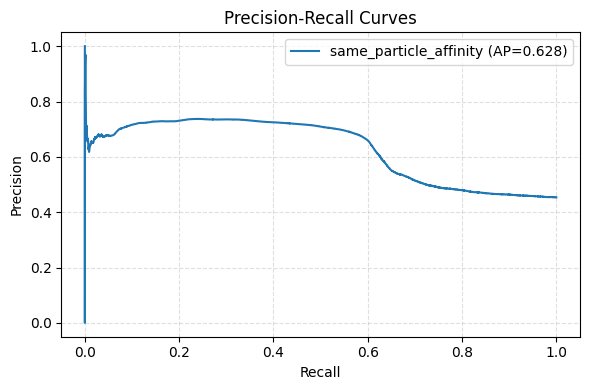

'/workspace/artifacts/validation_plots/event_splitter/event_splitter_20260219_021428_precision_recall.png'

In [9]:
# 3. Precision-Recall Curves
print("3. Generating precision-recall curves...")
plot_precision_recall_curves(
    predictions=predictions,
    targets=targets,
    class_names=class_names,
    save_path=plots_dir / f"{plot_prefix}_precision_recall.png",
    show=True,
)


### Probability Distributions

Inspect predicted affinity probabilities for positive and negative edges.


4. Generating probability distribution plots...


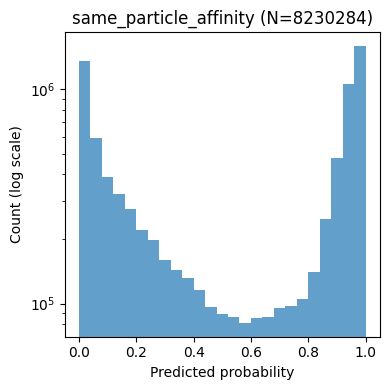

'/workspace/artifacts/validation_plots/event_splitter/event_splitter_20260219_021428_probability_distributions.png'

In [10]:
# 4. Probability Distributions
print("4. Generating probability distribution plots...")
plot_probability_distributions(
    predictions=predictions,
    targets=targets,
    class_names=class_names,
    save_path=plots_dir / f"{plot_prefix}_probability_distributions.png",
    show=True,
)


### Confidence Analysis

Confidence plots help verify whether predicted probabilities are informative and calibrated.


5. Generating confidence analysis plots...


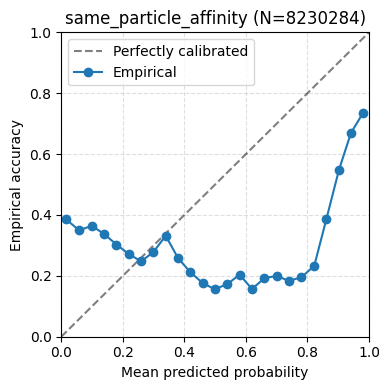

Saved validation plots to: /workspace/artifacts/validation_plots/event_splitter


In [11]:
# 5. Confidence Analysis
print("5. Generating confidence analysis plots...")
plot_confidence_analysis(
    predictions=predictions,
    targets=targets,
    class_names=class_names,
    save_path=plots_dir / f"{plot_prefix}_confidence_analysis.png",
    show=True,
)

print(f"Saved validation plots to: {plots_dir}")


## Optional: Read Saved Metrics

Read `metrics_latest.json` from the event-splitter prediction output directory if present.


In [12]:
metrics_path = export_info.get("metrics_path")
if metrics_path is None:
    print("metrics_path: <not found>")
else:
    metrics_path = Path(metrics_path)
    print("metrics_path:", metrics_path)
    print(metrics_path.read_text())


metrics_path: /workspace/data/event_splitter/metrics_latest.json
{
  "accuracy": null,
  "confusion": null,
  "exact_match": null,
  "loss": null,
  "mean_logit": 0.17631614003234883,
  "mode": "event_splitter",
  "model_path": "/workspace/trained_models/event_splitter/event_splitter_20260219_021339_torchscript.pt",
  "output_path": "/workspace/data/event_splitter/ml_output_000_preds.parquet",
  "output_paths": [
    "/workspace/data/event_splitter/ml_output_000_preds.parquet"
  ],
  "threshold": 0.5,
  "validated_endpoint_files": [
    "/workspace/data/endpoint_regressor/ml_output_000_preds.parquet"
  ],
  "validated_files": [
    "/workspace/data/ml_output_000.parquet"
  ],
  "validated_group_probs_files": [
    "/workspace/data/group_classifier/ml_output_000_preds.parquet"
  ],
  "validated_group_splitter_files": [
    "/workspace/data/group_splitter/ml_output_000_preds.parquet"
  ]
}
